# Salary Predictions Based on Job Descriptions

# DEFINE

### ---- Define the problem ----

##### Predicting Salary with the features factors Dataset
This notebook demonstrates the entire process of building a predictive model to suggest the employee salary range for HR and job seekers. All the processes involving defining problems, discovering dataset, developing model, and deploying into production have been divided into main sections. Salary range tends to vary, depending on factors such as experiences, education, previous job title, etc. This predictive analysis aims to build a scalable and deployable model to predict salary used by Human Resource Department and talent acquisition team.


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
# My information
__author__ = "Cho_Hang"
__email__ = "dsjoench@gmail.com"

In [3]:
## helper function 

#load csv data files 
def load_file(file):
    return pd.read_csv(file)

#merge data
def merge_data(df1, df2, key):
    return df1.merge(df2, on = key)

#clean data function
def clean_data(df):
    #removes rows where salary equals to zero
    return df[df.salary > 0]
#one hot encoding to transform categorical to dummy 

def plot_feature(df, col):
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.title('Distribution of {}'.format(col))
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df.sort_values('salary'))
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.title('Relationship of Salary with {}'.format(col))
    plt.show()
    
def encode_label(df, col):
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat]['salary'].mean()   
    df[col] = df[col].map(cat_dict)
    
def one_hot_encode(df, cat_vars=None, num_vars=None):
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)
    
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

## DISCOVER

### ---- Load the data ----

In [4]:
!ls -lh data/

total 269304
-rwxr-xr-x@ 1 ngjo  staff    56M Oct  8  2016 test_features.csv
-rwxr-xr-x@ 1 ngjo  staff    56M Oct  8  2016 train_features.csv
-rwxr-xr-x@ 1 ngjo  staff    20M Oct  8  2016 train_salaries.csv


In [5]:
train_fea = load_file('data/train_features.csv')
train_salary = load_file('data/train_salaries.csv')
test_set = load_file('data/test_features.csv')

In [6]:
print('The shape of the test set is {}'.format(test_set.shape))

The shape of the test set is (1000000, 8)


In [7]:
print('The shape of the train_fea is {}'.format(train_fea.shape))

The shape of the train_fea is (1000000, 8)


In [8]:
print('The shape of the train_salary is {}'.format(train_salary.shape))

The shape of the train_salary is (1000000, 2)


### ---- Inspect and clean the data ----

In [9]:
train_fea.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [10]:
train_salary.isnull().any()

jobId     False
salary    False
dtype: bool

In [11]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [12]:
train_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [13]:
train_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [14]:
# Merging the dataset train_salary and train_fea
train_merged = pd.merge(train_fea,train_salary, how='left', on='jobId')

In [15]:
# Look for duplicated values.
train_merged.duplicated().any()

False

In [16]:
#define variables
categorical_vars = [ 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

After some preprocessing and dataset, the merged training dataset looks clean.

### ---- Data Exploratory Analysis ----

#### At this stage, I am interested in the following questions to dive deep into the data.
1. Does certain major earn a higher salary in specific industry? 
2. Does achieving higher education always lead to a higher salary? 


In [17]:
train_merged.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [18]:
#review the summary statistics of the new merged dataset
train_merged.describe(include = 'all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000
unique,1000000,63,8,5,9,7,NaN,NaN,NaN
top,JOB1362685401584,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,1,16193,125886,236976,532355,143206,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992386,49.529260,116.061818
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212391,28.877733,38.717936
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


In [19]:
# Check if every record are unique
train_merged.jobId.nunique() == len(train_merged)

True

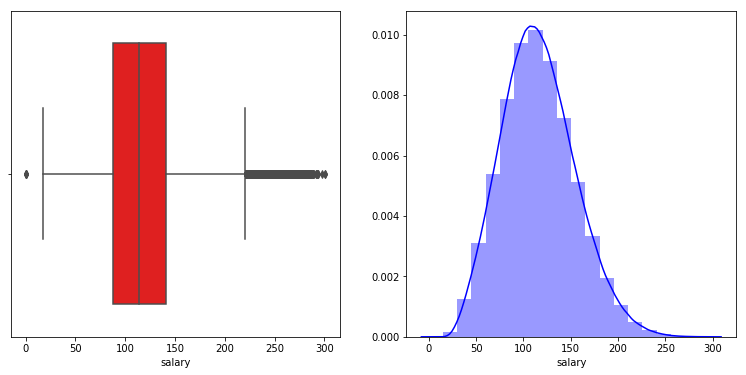

In [20]:
# Check the distribution of the target variable. 
plt.figure(figsize = (13, 6))
plt.subplot(1,2,1)
sns.boxplot(train_merged.salary,color = 'r')
plt.subplot(1,2,2)
sns.distplot(train_merged.salary, bins=20,color = 'b')
plt.show()

In [21]:
train_merged.salary.describe()

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

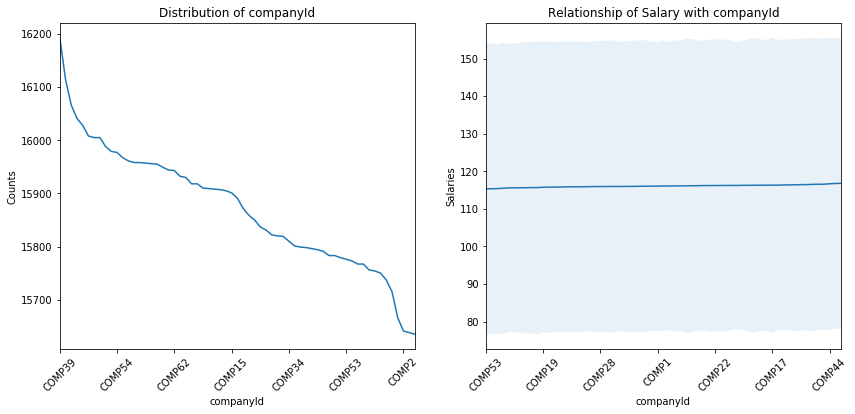

In [22]:
plot_feature(train_merged,'companyId')

##### Company_Id and salary doesn't appear to have a strong relationship

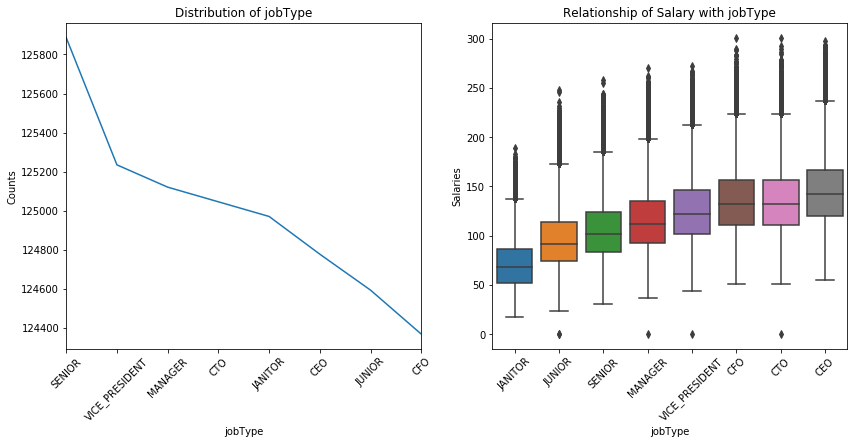

In [23]:
plot_feature(train_merged,'jobType')

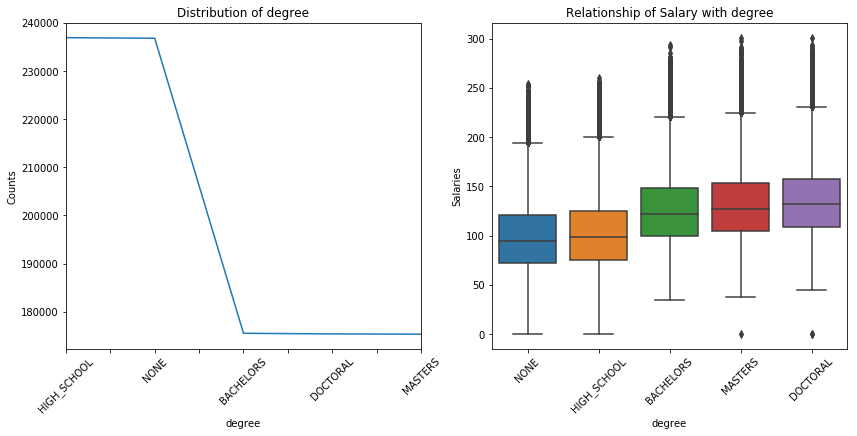

In [24]:
plot_feature(train_merged,'degree')

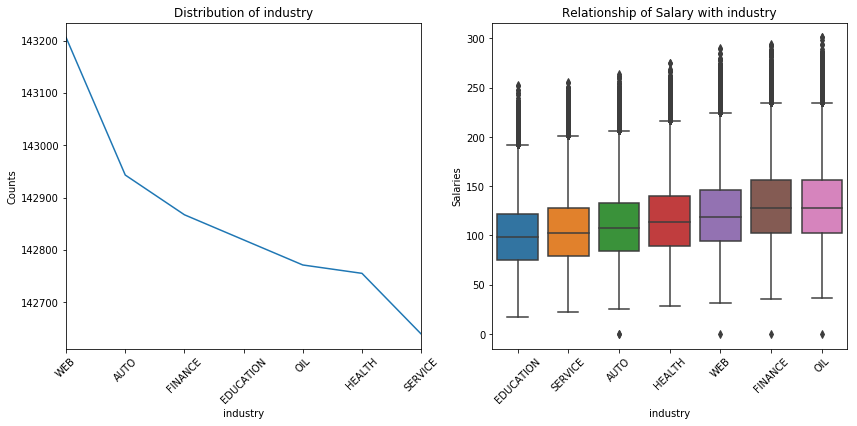

In [25]:
plot_feature(train_merged,'industry')

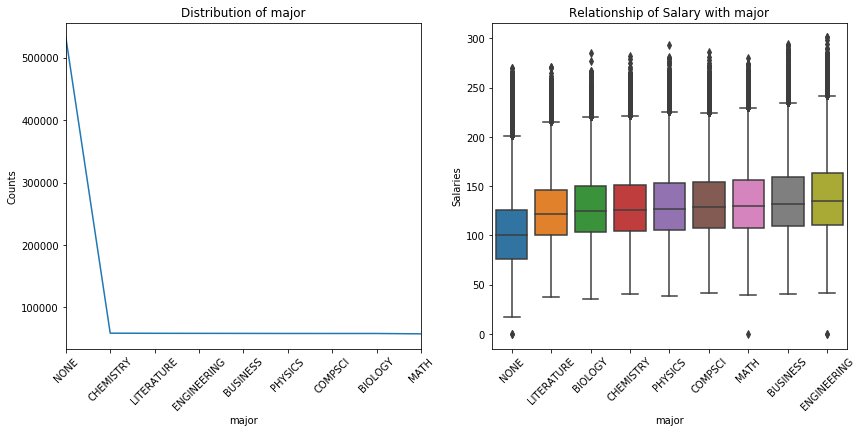

In [26]:
plot_feature(train_merged,'major')

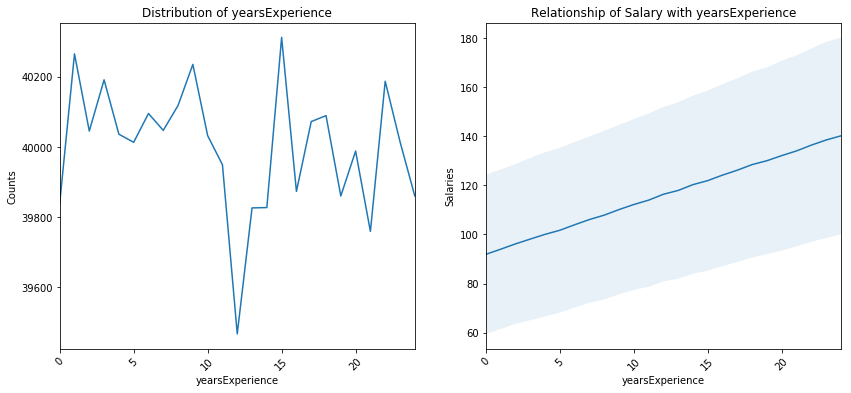

In [27]:
plot_feature(train_merged,'yearsExperience')

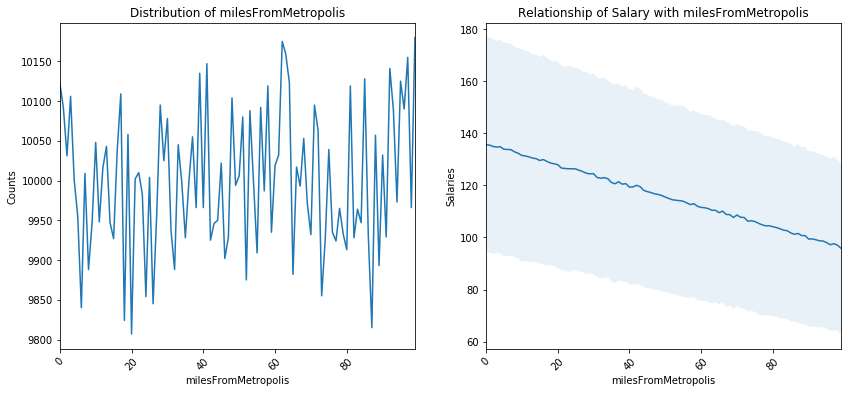

In [28]:
plot_feature(train_merged,'milesFromMetropolis')

#### Question : Does certain major earn a higher salary in specific industry?

In [29]:
industry_type = train_merged['industry'].unique()

<Figure size 432x288 with 0 Axes>

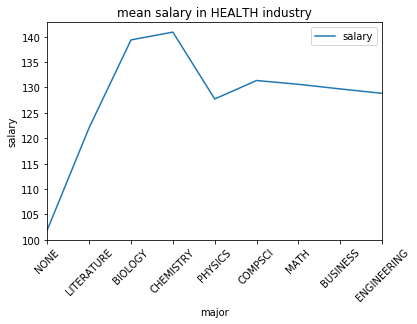

<Figure size 432x288 with 0 Axes>

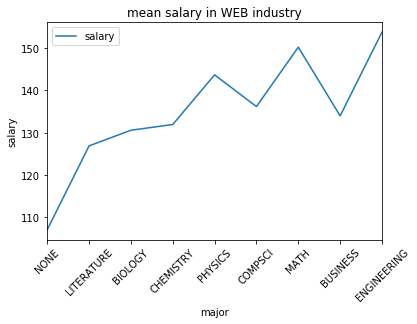

<Figure size 432x288 with 0 Axes>

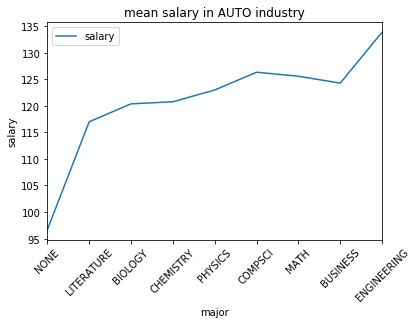

<Figure size 432x288 with 0 Axes>

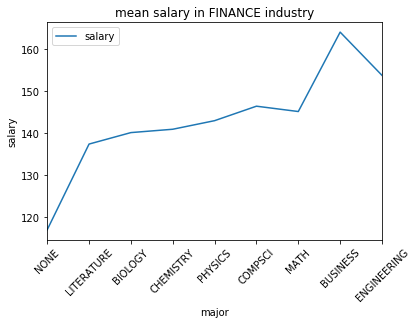

<Figure size 432x288 with 0 Axes>

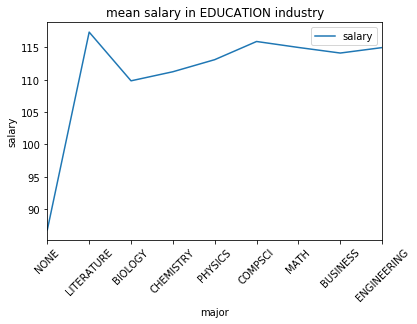

<Figure size 432x288 with 0 Axes>

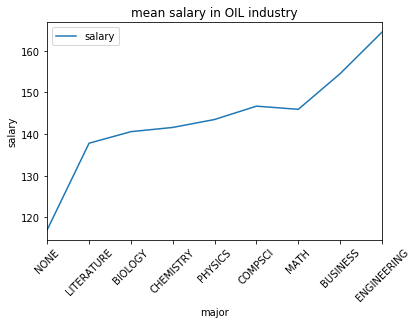

<Figure size 432x288 with 0 Axes>

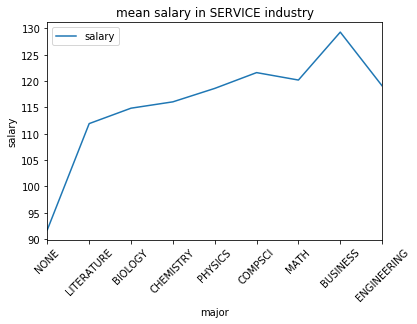

In [30]:
for i  in industry_type:
        plt.figure()
        train_merged[(train_merged['industry'] == i)][['major','salary']].groupby('major').mean().plot()
        plt.title('mean salary in {} industry'.format(i))
        plt.ylabel('salary')
        plt.xticks(rotation=45)
        plt.show()

##### Business major has the highest mean salary in the finance industry and service industry. Engineering major has the highest salary in the web, oil, and auto industries. Surprisingly, chemistry major earns more than the biology major in the health space. 

In [31]:
## Copy the dataset for correlation analysis

corr_train = train_merged.copy()

In [32]:
for i in corr_train.columns:
    if corr_train[i].dtype.name=='category':
        encode_label(corr_train,i)

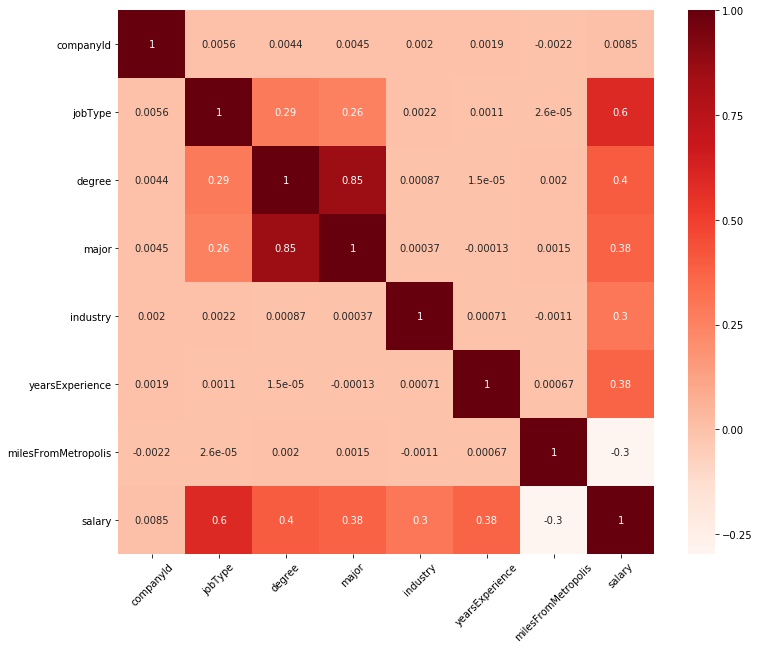

In [33]:
#look for correlation between each feature and the target
fig = plt.figure(figsize=(12, 10))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sns.heatmap(corr_train[features + ['salary']].corr(), cmap='Reds', annot=True)
plt.xticks(rotation=45)
plt.show()

In [55]:
train_feature = one_hot_encode(train_merged, cat_vars=categorical_vars, num_vars=numeric_vars)
test_feature = one_hot_encode(test_set, cat_vars=categorical_vars, num_vars=numeric_vars)

### ---- Establish a baseline (Linear Regression)----

In [35]:
# The following script divides data into attributes and labels:
X = train_feature
y = train_merged['salary']

In [36]:
# Split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [37]:
# Training the Algorithm using linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
# Prediction
y_pred = lr.predict(X_test) 
y_pred

array([136.91040039, 108.71496582, 170.57775879, ..., 124.89758301,
       150.92041016, 154.39733887])

In [38]:
# Mean square error will be used to define my model performance
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 386.6613182090142


### ---- 6 Hypothesize solution ----

The mean square error for the baseline model is 386, Let try to use random forest and gradient boosting algorithms to see if it will improve the MSE. 

## DEVELOP

### ---- Create models ---- 

#### Building Random Forest Model 

In [39]:
model_1 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40)
# Fiting data
model_1.fit(X_train,y_train)
# Prediction
y_pred1 = model_1.predict(X_test) 
y_pred1

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


array([147.53333333, 106.96666667, 173.3       , ..., 130.5       ,
       180.36666667, 147.9       ])

In [40]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred1))

Mean Squared Error: 468.71562921946577


### Tuning Random Forest Model

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 depth
MSE Train:  295.2957433180605
MSE Test:  713.0471427452835
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 depth
MSE Train:  170.40599617639572
MSE Test:  532.7086962321688
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 depth
MSE Train:  145.45424843010113
MSE Test:  496.0880834780514
 


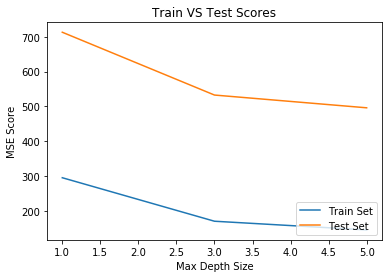

In [41]:
# Tuning max_depth_size
results  = []
results2 = []
max_depth_size  = [1,3,5]

for depth in max_depth_size:
    model = RandomForestRegressor(depth,n_jobs =-1 ,oob_score=True, random_state=44)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    mse1 = mean_squared_error(y_train, pred)
    mse2 = mean_squared_error(y_test, pred2)
    print('MSE Train: ', mse1)
    print('MSE Test: ', mse2)
    results.append(mse1)
    results2.append(mse2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('MSE Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 trees
AUC:  -5.4831049919989345
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 trees
AUC:  -1.8509024018418163
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 trees
AUC:  -0.3675270517769238
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


15 trees
AUC:  0.6583241446824931
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 trees
AUC:  0.6781327907776514
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


25 trees
AUC:  0.6850711408009955
 
40 trees
AUC:  0.6936255164309139
 
50 trees
AUC:  0.696336152104247
 


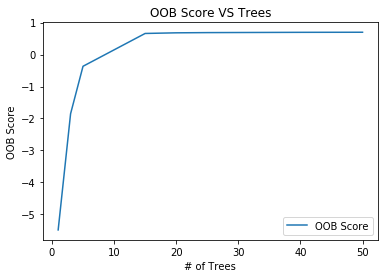

In [42]:
results = []
n_estimator_options = [1, 3, 5, 15, 20, 25, 40, 50]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, random_state=42)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(trees, 'trees')
    AUC = model.oob_score_
    print('AUC: ', AUC)
    results.append(AUC)
    print (" ")
    
plt.plot(n_estimator_options, results, label='OOB Score')
plt.xlabel('# of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")
plt.show()

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 min samples
AUC:  0.6850711408009955
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 min samples
AUC:  0.7256423621009249
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 min samples
AUC:  0.737842021670728
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


7 min samples
AUC:  0.7434732188479274
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


9 min samples
AUC:  0.7466984093781539
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 min samples
AUC:  0.7478571204563325
 
20 min samples
AUC:  0.7522628520789394
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


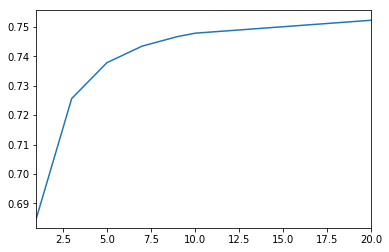

In [43]:
results_min_samples = []
min_samples_leaf_options = [1, 3, 5, 7, 9, 10, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=25, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results_min_samples.append(auc)
    print (" ")
    
pd.Series(results_min_samples, min_samples_leaf_options).plot()


#### Rebuild Random Forest with the updated parameters

In [44]:
model_2 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40,n_estimators=25, max_depth=25,min_samples_leaf =10)
model_2.fit(X_train,y_train)
y_pred2 = model_2.predict(X_test) 
print('Mean Squared Error:', mean_squared_error(y_test, y_pred2))

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Mean Squared Error: 373.37273660050755


#### Tuning Gradient Boosting 

In [45]:
results_depth=[]
for depth in [2,3,4,5]:
    clf = GradientBoostingRegressor(max_depth=depth)
    clf.fit(X_train, y_train)
    results_depth.append(
        {
            'max_depth': depth,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results_depth).set_index('max_depth').sort_index()
max_depth_lr

,test_error,train_error
max_depth,,
2,414.664658,411.165850
3,378.030053,374.929564
4,365.501019,362.591532
5,360.622242,357.377928


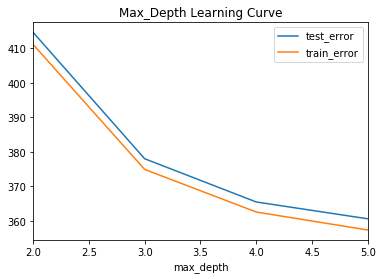

In [46]:
max_depth_lr.plot(title="Max_Depth Learning Curve")

In [47]:
results_learning=[]
for rate in [0.1,0.15,0.2,0.25,0.3]:
    clf = GradientBoostingRegressor(learning_rate=rate)
    clf.fit(X_train, y_train)
    results_learning.append(
        {
            'learning_rate': rate,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
learning_rate_lr = pd.DataFrame(results_learning).set_index('learning_rate').sort_index()
learning_rate_lr

,test_error,train_error
learning_rate,,
0.10,378.030053,374.929564
0.15,366.552115,364.013513
0.20,363.210084,361.176707
0.25,362.925959,360.622785
0.30,361.438818,359.333228


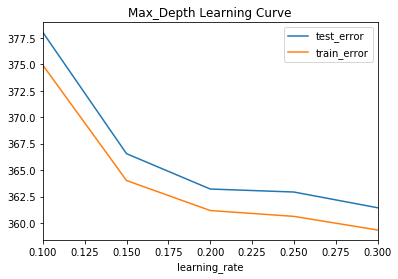

In [48]:
learning_rate_lr.plot(title="Max_Depth Learning Curve")

#### Building Gradient Boosting Model with the updated parameters

In [49]:
gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=150,loss='ls',learning_rate=0.2,random_state=5)
gbrt.fit(X_train,y_train)
# Prediction
y_pred_3 = gbrt.predict(X_test) 
y_pred_3

array([147.04235151, 101.76538893, 172.53371788, ..., 127.41572493,
       153.99760972, 151.72357756])

In [50]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_3))

Mean Squared Error: 358.4883016679009


### ----  5-Fold Cross Validation ----

In [51]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2


In [52]:
#create models -- hyperparameter tuning already done by hand for each model
lr_cv = LinearRegression()
rf_tuned = RandomForestRegressor(n_estimators=100, n_jobs=num_procs, max_depth=25,random_state=2)
gbm_tuned = GradientBoostingRegressor(n_estimators=150, max_depth=5,learning_rate = 0.2,random_state=3)
                      
models.extend([lr_cv, rf_tuned, gbm_tuned])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, X, y, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE:
 384.5163097712999
Standard deviation during CV:
 1.3585390870773892

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=2, verbose=0, warm_start=False)
Average MSE:
 422.6214412985119
Standard deviation during CV:
 0.9620311558590515

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_f

### ---- 10 Select best model  ----

In [56]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print_summary(model, mean_mse, cv_std)

#train model on entire dataset
model.fit(X, y)

#create predictions based on test data
predictions = model.predict(test_feature)



Predictions calculated using model with lowest MSE:

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, n_iter_no_change=None, presort='auto',
             random_state=3, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Average MSE:
 357.5663788466243
Standard deviation during CV:
 1.116972979997115


## DEPLOY

### ---- Automate pipeline ----

In [63]:
#write script that trains model on entire training set, saves model to disk, and scores the "test" dataset
def salary_prediction_pipeline(train_df, train_target, test_df):
    
    #load data
    print('Loading data...')
    train_df = load_file(train_df)
    train_target = load_file(train_target)
    test_df = load_file(test_df)
    
    #define variables
    categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
    numeric_vars = ['yearsExperience', 'milesFromMetropolis']
    target_var = 'salary'
    
    #merge data
    print('Merging data...')
    merged_df = merge_data(train_df, train_target, 'jobId')
    
    #clean data
    print('Cleaning data...')
    train_cleaned = clean_data(merged_df)
    
    #convert categorical variables to numerical for model building
    print('Converting data...')
    train_feature = one_hot_encode(train_cleaned, cat_vars=categorical_vars, num_vars=numeric_vars)
    test_feature = one_hot_encode(test_set, cat_vars=categorical_vars, num_vars=numeric_vars)

    
    #initialize model list and dicts
    print('initializing list...')
    train = train_feature
    target = train_cleaned['salary']
    test_df = test_feature
    models = []
    mean_mse = {}
    cv_std = {}
    res = {}

    #define number of processes to run in parallel
    num_procs = 2
    
    #initialize tuned models
    print('Initializing models...')
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, n_jobs=num_procs, max_depth=5)
    gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls',learning_rate = 0.2)
    models.extend([lr, rf, gbm])

    #parallel cross-validate models, using MSE as evaluation metric, and print summaries
    print("Cross validation...")
    for model in models:
        train_model(model, train, target, num_procs, mean_mse, cv_std)
        print_summary(model, mean_mse, cv_std)
    
    #train model on entire dataset
    print("Training model...")
    model.fit(train, target)

    #create predictions based on test data
    print("Prediction...")
    predictions = model.predict(test_df)
    
    #set index to 'feature'
    print("feature importance plotting...")
    rf.fit(test_df,target)
    feature_importances = pd.Series(rf.feature_importances_, index=test_df.columns)
    print(feature_importances)
    feature_importances.sort_values(inplace=True)
    feature_importances.plot(kind='barh', figsize=(7,6))
    

    #save results
    save_results(model, mean_mse[model], predictions, feature_importances)
    
    
    

### ---- Deploy solution ----

In [ ]:
salary_prediction_pipeline("data/train_features.csv", "data/train_salaries.csv", "data/test_features.csv")

### ---- Summary ----

###### Overall, Gradient Boosting gives me the best model prediction performance based on average MSE on cross-validation, which improves from 384 in the baseline model to 357 on the test data. Features importance tells me that miles from Metropolis would be a top relevant feature in prediction. This model could be improved on diving into the statistical analysis checking how certain features are related to each others. Inituiively, engineering major might be more positively correlated with salary in the technology industry and finace major could be more important in the finance industry. Further feature engineering can be done to improve the model. 